<h1> Trip Destination Analysis

**Project presentation:** This analysis was part of my final project for an intensive course (Data Science & AI Bootcamp at Vivadata).      
I decided to challenge myself by collecting my own data, even if it was not the easiest way to start this personal project.     
Finally, I believe that it helped to improve my web scraping, data cleaning, and data analysis skills. 

**Disclaimer:** This project does not reflect reality at all due to the lack of data, but it is interesting to look at it as an opportunity to practice.

**Goal:** The goal is to analyze trip destinations based on about 150 answers of a Google Form. 

![image](https://mylifesamovie.com/wp-content/uploads/2019/08/Screenshot-2019-08-30-at-2.56.17-PM.png)

In [1]:
# Imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from bs4 import BeautifulSoup


<h2> Data

<h3> Data collection

<h4> Dataset of countries and its alpha code (ISO2)

In [ ]:
filepath_country = os.path.join('..','..', 'data', 'Projet-final', 'country-code-fr.csv')

In [ ]:
data_fr = pd.read_csv(filepath_country)

In [ ]:
data_fr.head()

<h4> Web Scraping

We will use web scraping to get more information about the country that were visited and see if there is any correlation between age groups and destination choice for instance.

In order to collect infos on countries, we will be using the french website : https://planificateur.a-contresens.net/

![image](https://zupimages.net/up/19/49/30g7.png)

The 1st step is to analyze how the different URLs are constructed.

Ex: https://planificateur.a-contresens.net/europe/pays-FR-france.html

![image alt <](https://zupimages.net/up/19/49/ro4s.png)


At first sight, an URL for a random country is composed of : 
- name of the continent
- word 'pays'
- ISO2 code
- name of the country

So at the beginning, I found a dataset of countries, its associated continent and name in French. But after a bit of research on the URLs, I found out that only the ISO2 code is necessary to access the differents pages of the countries. 
Now that we have that info, the scraping will be much easier : only our previous dataset is needed. 

In [ ]:
# Building the BASE_URL 

BASE_URL = 'https://planificateur.a-contresens.net/'

In [ ]:
# Creation of the different characteristics of the countries : mean_temp, rainfall, budget (€/jour/pers), langue, visa requis.

data_fr['mean_temp'] = ''
data_fr['mean_rain'] = ''
data_fr['budget'] = ''
data_fr['language'] = ''
data_fr['visa_required'] = ''
data_fr['continent'] = ''

In [ ]:
# Get the mean temperature and rainfall for each country

for i in range(len(data_fr)):
    try:
        response = requests.get(BASE_URL + 'europe/pays-' + data_fr.iloc[i]['ISO2'] + '-' 
                                    + 'pays.html')
        soup = BeautifulSoup(response.text)

        # Get the mean temp for each country
        mean_temp_str = soup.find("div", {'class': 'note note-info'}).find('p').find_all('strong')[0].text
        mean_temp = float(mean_temp_str.split('°')[0])
        data_fr['mean_temp'].iloc[i] = mean_temp

        # Get the mean rain for each country
        mean_rain_str = soup.find("div", {'class': 'note note-info'}).find('p').find_all('strong')[1].text
        mean_rain = float(mean_rain_str.split('m')[0])
        data_fr['mean_rain'].iloc[i] = mean_rain

        # Get the budget
        budget_str = soup.find_all('div', {'class' : 'infos-detail-info'})[2].text.strip().split()[0]
        if budget_str == '?':
            data_fr['budget'].iloc[i] = None
        else:
            data_fr['budget'].iloc[i] = float(budget_str)

        # Get the language
        data_fr['language'].iloc[i] = soup.find_all('div', {'class' : 'infos-detail-info'})[5].text.strip()

        # Get the visa requirement 
        data_fr['visa_required'].iloc[i] = soup.find_all('div', {'class' : 'infos-detail-info'})[6].text.strip()
        
        # Get the continent
        data_fr['continent'].iloc[i] = soup.find_all('div', {'class' : 'infos-detail-info'})[0].text.strip()
        
    except:
        print(data_fr.iloc[i]['Pays'])

In [ ]:
data_fr['CountryId'] = [i for i in range(len(data_fr))]

In [ ]:
# Saving it in a CSV file

data_fr.to_csv('../../data/Projet-final/data_country.csv')

<h4> Google Form

![image](https://zupimages.net/up/19/49/cwkj.png)                            
![image](https://zupimages.net/up/19/49/s32u.png) 

<span style='font-size: 1.5em;'> **CSV file : Raw form (before cleaning)** </span>

![image](https://zupimages.net/up/19/49/k8j3.png)

<span style='font-size: 1.5em;'> **Cleaning process** </span>

In [57]:
filepath_form = os.path.join('..','..', 'data', 'Projet-final', 'voyages3.csv')
data_raw = pd.read_csv(filepath_form, na_values=' ')

In [58]:
data_raw.columns = ['None', 'age_group','voyage1', 'notev1', 'voyage2' , 'notev2', 'voyage3', 'notev3','cout', 'paysage', 'activ', 'confort', 'periode', 'meteo', 'poids'] 

In [59]:
# Creating UserId, useful to have a link between the 3 trips made by one user

data_raw['UserId'] = [i for i in range(len(data_raw))]

In [60]:
# Get dummies of age_group

data_raw = pd.concat([data_raw, pd.get_dummies(data_raw['age_group'])], axis=1)

In [61]:
# Creating columns for the new dataset

columns_data = ['UserId', 'voyage', 'note', 'cout', 'paysage', 'activ', 'confort', 'periode', 'meteo','cout_p', 'paysage_p', 'activ_p', 'confort_p', 'periode_p', 'meteo_p', '18-26 ans', '27-39 ans', '40-60 ans',
       'moins de 18 ans', 'plus de 60 ans' ]

In [62]:
data_reviews = pd.DataFrame(columns=columns_data)

In [63]:
# Replacing NA values by strings in order to split ';'

data_raw[['cout','paysage', 'meteo', 'periode', 'activ', 'confort']] = data_raw[['cout','paysage', 'meteo', 'periode', 'activ', 'confort']].fillna(value=' ')

In [64]:
# Getting list instead of strings 
for col in ['cout', 'paysage', 'activ', 'confort', 'periode', 'meteo', 'poids']:
    data_raw[col] = data_raw[col].apply(lambda x: x.split(';'))

In [65]:
# Iteration on the raw data to have a workable dataset

for i in range(len(data_raw)):
    for k in range(1,4):
        temp = []
        temp.append(data_raw['UserId'].iloc[i])
        temp.append(data_raw[f'voyage{k}'].iloc[i])
        temp.append(data_raw[f'notev{k}'].iloc[i])
        
        # get the different parameters 
        for col in ['cout', 'paysage', 'activ', 'confort', 'periode', 'meteo']:
            if f'Voyage n°{k}' in data_raw[col].iloc[i]:
                temp.append(1)
            else:
                temp.append(0)
                
        # weight of each parameters        
        for word in ['Le coût', 'Le paysage', 'Les activités', 'Le confort', 'La période', 'La météo']:
            if word in data_raw['poids'].iloc[i]:
                temp.append(2)
            else:
                temp.append(1)
                
        # integration of age_group
        temp.append(data_raw['18-26 ans'].iloc[i])
        temp.append(data_raw['27-39 ans'].iloc[i])
        temp.append(data_raw['40-60 ans'].iloc[i])
        temp.append(data_raw['moins de 18 ans'].iloc[i])
        temp.append(data_raw['plus de 60 ans'].iloc[i])
        
        
        # add line by line to the new dataframe 
        data_reviews.loc[len(data_reviews)] = temp
        

In [66]:
# Saving it to a new csv file :

data_reviews.to_csv('../../data/Projet-final/data_reviews.csv')

<h3> Loading data 

In [2]:
filepath_form = os.path.join('..','..', 'data', 'Projet-final', 'voyages3.csv')
data_travel = pd.read_csv(filepath_form, na_values=' ')
data_country = pd.read_csv('../../data/Projet-final/data_country.csv')
data_reviews = pd.read_csv('../../data/Projet-final/data_reviews.csv')

In [3]:
data_travel.columns = ['None', 'age_group','voyage1', 'notev1', 'voyage2' , 'notev2', 'voyage3', 'notev3','cout', 'paysage', 'activ', 'confort', 'periode', 'meteo', 'poids'] 

<h2> Data preparation

<h3> Global overview

In [10]:
data_travel.head(2)

,None,age_group,voyage1,notev1,voyage2,notev2,voyage3,notev3,cout,paysage,activ,confort,periode,meteo,poids
0,2019/11/09 10:58:45 AM UTC+1,18-26 ans,Danemark,7,Roumanie,9,Royaume-Uni,8,Voyage n°3,Voyage n°1,Voyage n°1;Voyage n°2;Voyage n°3,Voyage n°1;Voyage n°3,Voyage n°2;Voyage n°3,Voyage n°2;Voyage n°3,Le coût;Le paysage;Les activités;La météo
1,2019/11/09 11:15:01 AM UTC+1,27-39 ans,italie,8,portugal,7,états-unis,8,Voyage n°1;Voyage n°2,Voyage n°1;Voyage n°2,Voyage n°3,Voyage n°2;Voyage n°3,Voyage n°1;Voyage n°2;Voyage n°3,Voyage n°1;Voyage n°2,Le coût;Le paysage;Les activités;La météo


In [11]:
data_country.head(2)

,Pays,ISO2,mean_temp,mean_rain,budget,language,visa_required,continent,CountryId
0,Afghanistan,AF,16.9,358.0,37.0,"Persan, Pachto (pachtou)",OUI,Asie,0
1,Îles Aland,AX,6.3,529.4,NaN,Suédois,?,Europe,1


In [12]:
data_reviews.head()

,Unnamed: 0,UserId,voyage,note,cout,paysage,activ,confort,periode,meteo,...,paysage_p,activ_p,confort_p,periode_p,meteo_p,18-26 ans,27-39 ans,40-60 ans,moins de 18 ans,plus de 60 ans
0,0,0,Danemark,7,0,1,1,1,0,0,...,2,2,1,1,2,1,0,0,0,0
1,1,0,Roumanie,9,0,0,1,0,1,1,...,2,2,1,1,2,1,0,0,0,0
2,2,0,Royaume-Uni,8,1,0,1,1,1,1,...,2,2,1,1,2,1,0,0,0,0
3,3,1,italie,8,1,1,0,0,1,1,...,2,2,1,1,2,0,1,0,0,0
4,4,1,portugal,7,1,1,0,1,1,1,...,2,2,1,1,2,0,1,0,0,0


<h3> Data cleaning

In [16]:
# Getting rid of special characters

def clean_country(country):
    return country.lower().strip().replace("é", "e").replace("è","e").replace("ï","i").replace('î','i').replace("-"," ").replace("ç", "c").replace("ô","o").capitalize().strip()

After building a cleaning function, we need to apply it to the 2 datasets:

In [17]:
data_reviews['voyage'] = data_reviews['voyage'].apply(clean_country)

In [48]:
data_country['Pays'] = data_country['Pays'].apply(clean_country)

In [18]:
data_reviews['voyage'].unique()

array(['Danemark', 'Roumanie', 'Royaume uni', 'Italie', 'Portugal',
       'Etats unis', 'Norvege', 'Hongrie', 'Cuba', 'Espagne', 'Pays bas',
       'Thailande', 'Tanzanie', 'Japon', 'Kenya', 'Philippines',
       'Republique tcheque', 'Allemagne', 'France', 'Croatie',
       'Sainte lucie', 'Madagascar', 'Egypte', 'Perou', 'Bresil',
       'Cambodge', 'Guadeloupe', 'Tunisie', 'Canarie', 'Irlande',
       'Barbade', 'Grece', 'Belgique', 'Dominique', 'New york',
       'Martinique', 'Bulgarie', 'Grenade', 'Afrique du sud', 'Canada',
       'Vietnam', 'Crete', 'Sri lanka', 'Maroc', 'Senegal', 'Malte',
       'Cameroun', 'Suisse', 'Australie', 'Mexique', 'Jamaique', 'Suede',
       'Puerto rico', 'Inde', "Cote d'ivoire", 'Benin', 'Nepal',
       'Republique dominicaine', 'Maurice', 'Hong kong', 'Malaisie',
       'Saint martin', 'Guyane', 'Luxembourg', 'Autriche', 'Islande',
       'Etat unis', 'Guyane francaise', 'Paris', 'Curacao',
       'Republique domincaine', 'Singapour', 'Indonesie

Now we have cleaned our data, there are only one way that our countries are written.

<h2> Analysis

<h3> Global Overview

To begin with, what's the age group distribution ? 

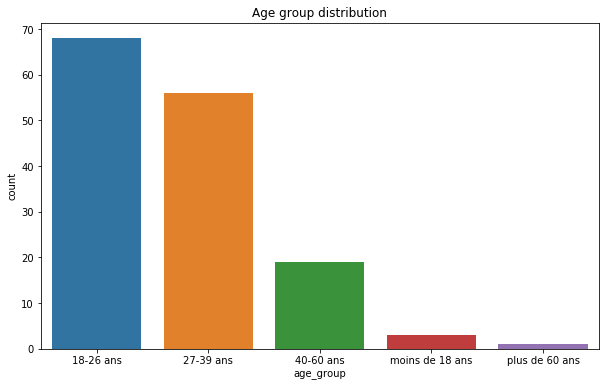

In [19]:
plt.figure(figsize=(10,6))

sns.countplot(data_travel['age_group'])
plt.title('Age group distribution')

plt.show()

<h3> Top 10 visited countries

In [20]:
most_visited_country = data_reviews['voyage'].value_counts().iloc[:10]
most_visited_country

Espagne        49
Italie         36
Guadeloupe     34
Etats unis     31
France         24
Royaume uni    22
Pays bas       17
Allemagne      16
Portugal       15
Suisse         10
Name: voyage, dtype: int64

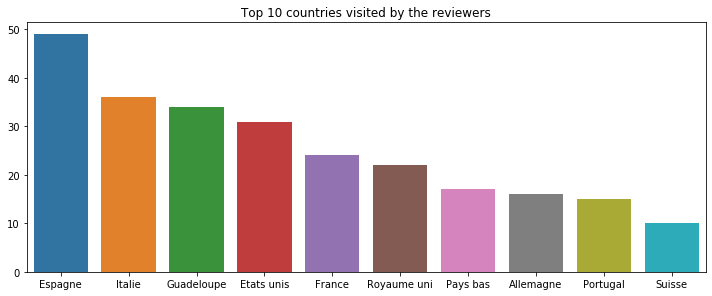

In [21]:
plt.figure(figsize=(10,4))

sns.barplot(most_visited_country.index,
            most_visited_country.values)
plt.tight_layout()
plt.title('Top 10 countries visited by the reviewers')

plt.show()

In [22]:
data_10 = data_reviews[data_reviews['voyage'].isin(most_visited_country.index)]

In [23]:
data_10.shape

(254, 21)

In [24]:
data_10['voyage'].unique()

array(['Royaume uni', 'Italie', 'Portugal', 'Etats unis', 'Espagne',
       'Pays bas', 'Allemagne', 'France', 'Guadeloupe', 'Suisse'],
      dtype=object)

In [25]:
visited_countries = [data_10.loc[data_10['18-26 ans'] == 1]['voyage'].values, 
                     data_10.loc[data_10['27-39 ans'] == 1]['voyage'].values,
                     data_10.loc[data_10['40-60 ans'] == 1]['voyage'].values,
                     data_10.loc[data_10['moins de 18 ans'] == 1]['voyage'].values,
                     data_10.loc[data_10['plus de 60 ans'] == 1]['voyage'].values]
visited_countries

[array(['Royaume uni', 'Espagne', 'Portugal', 'Italie', 'Portugal',
        'Guadeloupe', 'Etats unis', 'Pays bas', 'Royaume uni', 'Allemagne',
        'Suisse', 'Pays bas', 'Royaume uni', 'Portugal', 'Guadeloupe',
        'Allemagne', 'Espagne', 'Pays bas', 'Espagne', 'Royaume uni',
        'Etats unis', 'Pays bas', 'Espagne', 'Royaume uni', 'Espagne',
        'Pays bas', 'Guadeloupe', 'Guadeloupe', 'France', 'Italie',
        'Etats unis', 'Suisse', 'Royaume uni', 'Espagne', 'Allemagne',
        'Guadeloupe', 'Pays bas', 'Guadeloupe', 'Espagne', 'Etats unis',
        'Espagne', 'Guadeloupe', 'Guadeloupe', 'France', 'Espagne',
        'Guadeloupe', 'Espagne', 'Guadeloupe', 'France', 'Italie',
        'Guadeloupe', 'France', 'Espagne', 'Guadeloupe', 'Royaume uni',
        'Espagne', 'Royaume uni', 'Guadeloupe', 'Espagne', 'Etats unis',
        'Espagne', 'Pays bas', 'Italie', 'Espagne', 'Italie', 'Italie',
        'Italie', 'Allemagne', 'Portugal', 'Guadeloupe', 'Espagne',
        'Esp

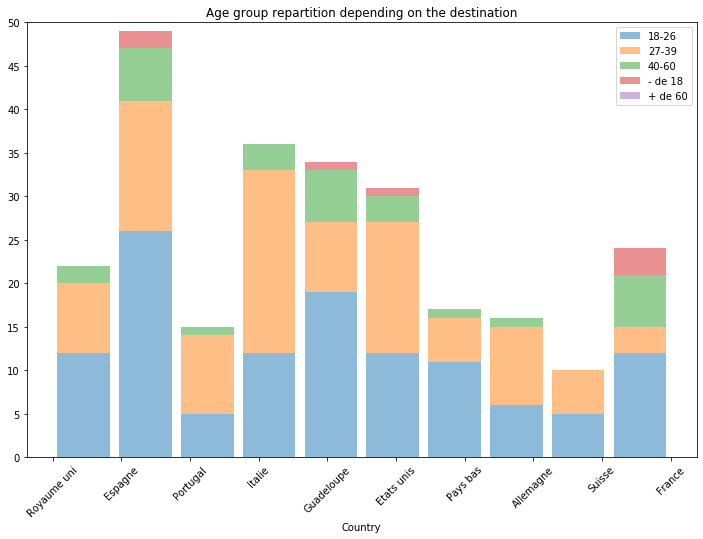

In [128]:
plt.figure(figsize=(12,8))
colors = ['18-26', '27-39', '40-60', '- de 18', '+ de 60']
plt.hist(visited_countries, stacked=True, label=colors, alpha=0.5, rwidth=0.85)
plt.legend()
plt.title('Age group repartition depending on the destination')
plt.xlabel('Country')
plt.xticks(rotation='45')
plt.yticks(np.arange(0,55,5))
plt.show()

<h3> Why Spain appears to be the most visited country ? 

In [26]:
data_spain = data_reviews.loc[data_reviews['voyage'] == 'Espagne']

In [27]:
data_spain.head()

,Unnamed: 0,UserId,voyage,note,cout,paysage,activ,confort,periode,meteo,...,paysage_p,activ_p,confort_p,periode_p,meteo_p,18-26 ans,27-39 ans,40-60 ans,moins de 18 ans,plus de 60 ans
11,11,3,Espagne,8,1,1,1,1,1,1,...,2,2,2,1,2,0,1,0,0,0
14,14,4,Espagne,8,1,1,0,0,0,1,...,2,1,1,1,2,0,1,0,0,0
23,23,7,Espagne,8,0,1,0,0,0,0,...,2,2,1,1,2,0,1,0,0,0
30,30,10,Espagne,9,0,1,0,1,0,1,...,2,1,2,1,2,0,1,0,0,0
40,40,13,Espagne,9,0,0,0,1,0,1,...,2,2,2,2,1,0,1,0,0,0


In [28]:
data_spain['cout'].mean()

0.6938775510204082

In [29]:
data_country.loc[(data_country['Pays'] == 'Espagne') | (data_country['Pays'] == 'France')]

,Pays,ISO2,mean_temp,mean_rain,budget,language,visa_required,continent,CountryId
74,France,FR,11.4,750.3,60.0,Français,?,Europe,74
202,Espagne,ES,15.3,512.6,65.0,"Espagnol, castillan",NON,Europe,202


Around 70% of the reviewers that went to Spain were satisfied of the cost of living there. This information can be correlated with a review about the cost of living in Spain in 2019.        
[source](https://www.ou-et-quand.net/budget/espagne/)

![image](https://zupimages.net/up/19/49/49uu.png)

In [37]:
data_spain.describe()

,UserId,note,cout,paysage,activ,confort,periode,meteo,cout_p,paysage_p,activ_p,confort_p,periode_p,meteo_p,18-26 ans,27-39 ans,40-60 ans,moins de 18 ans,plus de 60 ans
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.0
mean,74.367347,8.367347,0.693878,0.755102,0.551020,0.510204,0.510204,0.734694,1.734694,1.653061,1.530612,1.428571,1.285714,1.591837,0.530612,0.306122,0.122449,0.040816,0.0
std,43.261653,1.130890,0.465657,0.434483,0.502545,0.505076,0.505076,0.446071,0.446071,0.480929,0.504234,0.500000,0.456435,0.496587,0.504234,0.465657,0.331201,0.199915,0.0
min,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,30.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,81.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.0
75%,108.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.0
max,146.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.0


Overall, around 75% of the reviewers liked the landscape, and 73% liked the weather.

<h3> Comparison with the 2nd most visited country : Italy

In [121]:
data_italy = data_reviews.loc[data_reviews['voyage'] == 'Italie']

In [124]:
data_italy.describe()

,UserId,note,cout,paysage,activ,confort,periode,meteo,cout_p,paysage_p,activ_p,confort_p,periode_p,meteo_p,18-26 ans,27-39 ans,40-60 ans,moins de 18 ans,plus de 60 ans,charac_mark
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0,36.0,36.0
mean,78.750000,7.750000,0.527778,0.750000,0.472222,0.388889,0.500000,0.555556,1.694444,1.833333,1.444444,1.166667,1.305556,1.638889,0.333333,0.583333,0.083333,0.0,0.0,0.0
std,45.260121,0.840918,0.506309,0.439155,0.506309,0.494413,0.507093,0.503953,0.467177,0.377964,0.503953,0.377964,0.467177,0.487136,0.478091,0.500000,0.280306,0.0,0.0,0.0
min,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,44.500000,7.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,78.500000,8.000000,1.000000,1.000000,0.000000,0.000000,0.500000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0
75%,115.500000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0
max,146.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0


![image](https://zupimages.net/up/19/49/4tzv.png)

[source](https://www.ou-et-quand.net/budget/espagne/)

<h3> Which of the 10 most visited countries has the best mark ? 

In order to integrate the weights of each characteristic, we will create a second mark :       

characteristic mark = $ \frac{\sum characnotation * weight * 10}{18}$  

The global mark will be the sum of the variable note and the characteristic mark :     
global_mark = note + characteristic_mark

In [30]:
def get_charac_mark(x):
    res = 0
    for k in ['cout', 'paysage', 'activ',
       'confort', 'periode', 'meteo']:
        res += x[k] * x[f'{k}_p']
    res = round((res * 10) / 18, 2)
    return res
    

In [31]:
data_10['charac_mark'] = 0

/home/al/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
data_10['charac_mark'].iloc[0] = get_charac_mark(data_10.iloc[0])

/home/al/bin/anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/al/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
for i in range(data_10.shape[0]):
    data_10['charac_mark'].iloc[i] = get_charac_mark(data_10.iloc[i])

/home/al/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
def global_mark(x):
    res = x['note'] + x['charac_mark']
    return res

In [35]:
data_10['global_mark'] = 0
for i in range(data_10.shape[0]):
    data_10['global_mark'].iloc[i] = global_mark(data_10.iloc[i])

/home/al/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/al/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
data_10.head()

,Unnamed: 0,UserId,voyage,note,cout,paysage,activ,confort,periode,meteo,...,confort_p,periode_p,meteo_p,18-26 ans,27-39 ans,40-60 ans,moins de 18 ans,plus de 60 ans,charac_mark,global_mark
2,2,0,Royaume uni,8,1,0,1,1,1,1,...,1,1,2,1,0,0,0,0,4.44,12.44
3,3,1,Italie,8,1,1,0,0,1,1,...,1,1,2,0,1,0,0,0,3.89,11.89
4,4,1,Portugal,7,1,1,0,1,1,1,...,1,1,2,0,1,0,0,0,4.44,11.44
5,5,1,Etats unis,8,0,0,1,1,1,0,...,1,1,2,0,1,0,0,0,2.22,10.22
10,10,3,Etats unis,9,1,0,1,1,1,1,...,2,1,2,0,1,0,0,0,5.00,14.00


In [39]:
data_10[['voyage', 'note', 'charac_mark', 'global_mark']]

,voyage,note,charac_mark,global_mark
2,Royaume uni,8,4.44,12.44
3,Italie,8,3.89,11.89
4,Portugal,7,4.44,11.44
5,Etats unis,8,2.22,10.22
10,Etats unis,9,5.00,14.00
...,...,...,...,...
434,Italie,9,3.33,12.33
436,France,5,1.11,6.11
438,Italie,7,1.67,8.67
439,Suisse,8,2.78,10.78


In [40]:
x = []
y = []
for i in range(len(most_visited_country.index)):
    x.append(most_visited_country.index[i])
    y.append(round(data_10.loc[data_10['voyage'] == most_visited_country.index[i]]['global_mark'].mean(),2))
    print(f"The mean global mark of {most_visited_country.index[i]}  is : {round(data_10.loc[data_10['voyage'] == most_visited_country.index[i]]['global_mark'].mean(),2)}")

The mean global mark of Espagne  is : 11.77
The mean global mark of Italie  is : 10.7
The mean global mark of Guadeloupe  is : 12.56
The mean global mark of Etats unis  is : 11.58
The mean global mark of France  is : 9.82
The mean global mark of Royaume uni  is : 11.45
The mean global mark of Pays bas  is : 10.67
The mean global mark of Allemagne  is : 10.1
The mean global mark of Portugal  is : 11.69
The mean global mark of Suisse  is : 10.02


In [50]:
data_country.loc[data_country['Pays'].isin(most_visited_country.index)]

,Pays,ISO2,mean_temp,mean_rain,budget,language,visa_required,continent,CountryId
74,France,FR,11.4,750.3,60.0,Français,?,Europe,74
81,Allemagne,DE,8.9,653.5,49.0,Allemand,NON,Europe,81
87,Guadeloupe,GP,26.0,1754.3,98.0,Français,?,Amérique du nord,87
106,Italie,IT,13.9,707.8,58.0,Italien,NON,Europe,106
152,Pays bas,NL,9.9,789.1,56.0,"Néerlandais, flamand",NON,Europe,152
172,Portugal,PT,15.3,783.4,58.0,"Portugais, Mirandais",NON,Europe,172
202,Espagne,ES,15.3,512.6,65.0,"Espagnol, castillan",NON,Europe,202
209,Suisse,CH,7.9,1204.7,55.0,"Allemand, Français, Italien",NON,Europe,209
228,Royaume uni,GB,8.9,970.4,79.0,"Anglais, Gallois",NON,Europe,228
229,Etats unis,US,12.0,763.4,94.0,Anglais,Autorisation eléctronique,Amérique du nord,229


**Conclusion:** Except the United States and Guadeloupe, all of these countries are located in Europe. We can suppose that these countries are in the Top 10 because the majority of the answers were submitted by 18-26 years old. So, we might conclude that since this category represents young adults, mostly students and young workers, maybe they have less means to go farther than other older categories of people.     
Lastly, I want to emphasize the fact that these are all assumptions based on my results. 

**Presentation part** : For those who are interested, I will try to upload the presentation I gave for this final project on my very last day at Vivadata. 